In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder 
from torch.utils.data.dataset import TensorDataset
from torchvision import transforms
from torchvision.models import vgg16_bn
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F

from utils import make_validation, make_sample, save_array, load_array
from train_utils import fit, predict, predict_labels

In [2]:
path = '/home/austin/data/fish/'
# path = '/home/austin/data/fish/sample/'

## Setup Directories

In [3]:
# make_validation(path, 500) # 500 images for validation
# make_sample(path, 400, 200) # 500 test / 200 val sample

## Create Datasets

In [4]:
data_transforms = transforms.Compose([transforms.Scale(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train = ImageFolder(path+'train', transform=data_transforms)
val = ImageFolder(path+'valid', transform=data_transforms)

## Fine tuning

In [5]:
vgg = vgg16_bn(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
    
vgg.classifier._modules['6'] = nn.Linear(4096, 8)

In [6]:
vgg.cuda();

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg.classifier._modules['6'].parameters(), lr=1e-3)

In [9]:
history = fit(vgg, train, criterion, optimizer, validation_data=val, nb_epoch=3)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 1.1316 - acc: 0.5959 - val_loss: 0.8039 - val_acc: 0.7234]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.7537 - acc: 0.7411 - val_loss: 0.6878 - val_acc: 0.7609]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.6675 - acc: 0.7731 - val_loss: 0.6024 - val_acc: 0.8180]



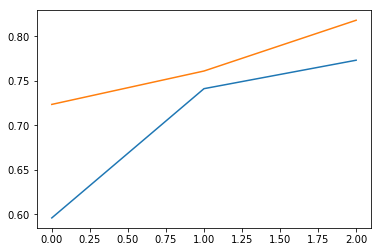

In [10]:
plt.plot(history['acc'])
plt.plot(history['val_acc']);

## Precompute Conv Features

In [7]:
conv_feat= predict(vgg.features, train, 32)
conv_val_feat = predict(vgg.features, val, 32)

## Save Features

In [10]:
%time save_array(path+'results/conv_feat.dat', conv_feat)
%time save_array(path+'results/conv_val_feat.dat', conv_val_feat)

CPU times: user 992 ms, sys: 84 ms, total: 1.08 s
Wall time: 272 ms
CPU times: user 1.05 s, sys: 52 ms, total: 1.1 s
Wall time: 318 ms


In [11]:
%time conv_feat = load_array(path+'results/conv_feat.dat')
%time conv_val_feat = load_array(path+'results/conv_val_feat.dat')

CPU times: user 316 ms, sys: 56 ms, total: 372 ms
Wall time: 119 ms
CPU times: user 220 ms, sys: 288 ms, total: 508 ms
Wall time: 143 ms


In [12]:
fnames_train, target_train = list(zip(*train.imgs))
fnames_val, target_val = list(zip(*val.imgs))

In [79]:
conv_feat = torch.from_numpy(conv_feat_large)
target_train = torch.Tensor(target_train).long()

conv_val_feat = torch.from_numpy(conv_val_feat)
target_val = torch.Tensor(target_val).long()

In [90]:
train_f = TensorDataset(conv_feat, target_train)
val_f = TensorDataset(conv_val_feat, target_val)

## Simple model with Conv features

In [91]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.batch_norm1 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 3 * 3, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.pool(x)
        x = self.batch_norm1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm3(x)
        x = self.fc3(x)
        return x

In [92]:
model1 = SimpleModel()

In [93]:
model1.cuda()

SimpleModel (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (batch_norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (4608 -> 512)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear (512 -> 512)
  (batch_norm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear (512 -> 8)
)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model1.parameters(), lr=1e-3)

In [95]:
history = fit(model1, train_f, criterion, optimizer, validation_data=val_f, nb_epoch=3)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 0.6269 - acc: 0.8275 - val_loss: 0.2816 - val_acc: 0.9180]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.1045 - acc: 0.9703 - val_loss: 0.2274 - val_acc: 0.9363]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.0470 - acc: 0.9870 - val_loss: 0.2295 - val_acc: 0.9395]


In [96]:
optimizer = Adam(model1.parameters(), lr=1e-4)
history = fit(model1, train_f, criterion, optimizer, validation_data=val_f, nb_epoch=3)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 0.0126 - acc: 0.9979 - val_loss: 0.1581 - val_acc: 0.9547]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.0078 - acc: 0.9982 - val_loss: 0.1762 - val_acc: 0.9469]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.0030 - acc: 0.9997 - val_loss: 0.1790 - val_acc: 0.9547]


In [97]:
optimizer = Adam(model1.parameters(), lr=1e-4)
history = fit(model1, train_f, criterion, optimizer, validation_data=val_f, nb_epoch=7)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 0.0024 - acc: 1.0000 - val_loss: 0.2069 - val_acc: 0.9520]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.0015 - acc: 0.9997 - val_loss: 0.1984 - val_acc: 0.9508]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.0026 - acc: 0.9994 - val_loss: 0.2356 - val_acc: 0.9520]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 4 - loss: 0.0024 - acc: 0.9994 - val_loss: 0.2200 - val_acc: 0.9469]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 5 - loss: 0.0009 - acc: 1.0000 - val_loss: 0.2094 - val_acc: 0.9531]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 6 - loss: 0.0005 - acc: 1.0000 - val_loss: 0.2163 - val_acc: 0.9520]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 7 - loss: 0.0015 - acc: 0.9993 - val_loss: 0.2344 - val_acc: 0.9500]


## FCN
- fully convolutional model with VGG features
- use 400 x 600 image features

In [ ]:
data_transforms = transforms.Compose([transforms.Scale((400, 600)),
                                      transforms.CenterCrop((400, 600)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train = ImageFolder(path+'train', transform=data_transforms)
val = ImageFolder(path+'valid', transform=data_transforms)

In [18]:
conv_feat_large = predict(vgg.features, train, 8)
conv_val_feat_large = predict(vgg.features, val, 8)

%time save_array(path+'results/conv_feat_large.dat', conv_feat_large)
%time save_array(path+'results/conv_val_feat_large.dat', conv_val_feat_large)


CPU times: user 6.25 s, sys: 428 ms, total: 6.68 s
Wall time: 1.65 s
CPU times: user 1.02 s, sys: 44 ms, total: 1.06 s
Wall time: 407 ms


In [19]:
%time conv_feat_large = load_array(path+'results/conv_feat_large.dat')
%time conv_val_feat_large = load_array(path+'results/conv_val_feat_large.dat')

conv_feat_large = torch.from_numpy(conv_feat_large)
conv_val_feat_large = torch.from_numpy(conv_val_feat_large)

train_f_l = TensorDataset(conv_feat_large, target_train)
val_f_l = TensorDataset(conv_val_feat_large, target_val)

CPU times: user 1.87 s, sys: 896 ms, total: 2.77 s
Wall time: 3.2 s
CPU times: user 320 ms, sys: 92 ms, total: 412 ms
Wall time: 372 ms


AttributeError: 'tuple' object has no attribute 'size'

In [20]:
conv_feat_large.size()

torch.Size([3277, 512, 12, 18])

In [ ]:
type(target_train)

In [17]:
conv_val_feat_l.size()

torch.Size([500, 512, 12, 18])

In [143]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.bn_input = nn.BatchNorm2d(512)
        self.conv1 = nn.Conv2d(512 , 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128 , 8, 3)
        self.bn2 = nn.BatchNorm2d(8)
        self.global_pool = nn.AvgPool2d(3)

    def forward(self, x):
        x = self.bn_input(x)
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.global_pool(x)
        return x.squeeze()

In [144]:
fcn = FCN()

In [145]:
fcn.cuda()

FCN (
  (bn_input): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (global_pool): AvgPool2d (size=3, stride=3, padding=0, ceil_mode=False, count_include_pad=True)
)

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(fcn.parameters(), lr=1e-3)

In [147]:
history = fit(fcn, train_f, criterion, optimizer, validation_data=val_f, nb_epoch=3)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 1.3926 - acc: 0.6896 - val_loss: 1.0086 - val_acc: 0.8727]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.9269 - acc: 0.9246 - val_loss: 0.8342 - val_acc: 0.9359]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.7293 - acc: 0.9772 - val_loss: 0.6935 - val_acc: 0.9508]


In [148]:
history = fit(fcn, train_f, criterion, optimizer, validation_data=val_f, nb_epoch=6)

Train on 3277 samples, Validate on 500 samples


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 1 - loss: 0.6012 - acc: 0.9894 - val_loss: 0.5911 - val_acc: 0.9473]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 2 - loss: 0.4983 - acc: 0.9927 - val_loss: 0.5447 - val_acc: 0.9508]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 3 - loss: 0.4147 - acc: 0.9971 - val_loss: 0.4654 - val_acc: 0.9637]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 4 - loss: 0.3613 - acc: 0.9970 - val_loss: 0.4142 - val_acc: 0.9578]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 5 - loss: 0.3017 - acc: 0.9991 - val_loss: 0.3874 - val_acc: 0.9590]


Widget Javascript not detected.  It may not be installed or enabled properly.


[Epoch 6 - loss: 0.2888 - acc: 0.9926 - val_loss: 0.3541 - val_acc: 0.9531]


In [ ]:
predict(fcn.conv2())